# Identifing Project Groupings

Looking into the different agencies, Locodes and Project IDs to identify instances of multiple oblgiations for the same project or type of funding in the same timeframe. 

Will look into various geographical locations, as well as the County with the most obligations, Humboldt County. 


In [1]:
import pandas as pd
from siuba import _, mutate, count, filter, group_by, ungroup, summarize, show_query, arrange, collect

import numpy as np
from sqlalchemy import create_engine
from siuba.sql import LazyTbl

In [6]:
#! pip install plotnine

In [3]:
from plotnine import *

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

In [5]:
df = pd.read_csv('gs://calitp-analytics-data/data-analyses/dla/e-76Obligated/clean_obligated_waiting.csv', low_memory=False)

/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:73: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/


In [7]:
df.head()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
0,0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaN,NaN,NON-MPO,NaN,5904,121,True
1,1,Obligated,ER,32D0(008),Mendocino County,2018-12-17,2018-12-19,2018-12-20,2018-12-20,2018-12-27,11508.00,0.00,13000.00,Authorized,5910,1,E-76 approved on,1.00,1.00,7.00,NaN,"Comptche Ukiah Road, Cr 223 Pm 17.25",Permanent Restoration,3,2018-12-17,2018-12-18,NON-MPO,NaN,32D0,8,False
2,2,Obligated,ER,4820(004),Humboldt County,2018-12-07,2018-12-21,2018-12-21,2018-12-21,2018-12-27,45499.64,0.00,51394.58,Authorized,5904,1,E-76 approved on,14.00,0.00,6.00,NaN,Mattole Rd Pm 43.17,Permanent Restoration,5,2018-12-06,2018-12-07,NON-MPO,NaN,4820,4,False
3,3,Obligated,CML,5924(244),Sacramento County,2018-12-11,2018-12-11,2018-12-21,2018-12-27,2018-12-27,207002.00,0.00,247002.00,Authorized,5924,3,E-76 approved on,4.00,16.00,0.00,SAC25086,Fair Oaks Blvd. Between Howe Ave And Munroe St,Create A Smart Growth Corridor With Barrier Se...,1,2018-12-07,2018-12-07,SACOG,NaN,5924,244,True
4,4,Obligated,CML,5924(214),Sacramento County,2018-12-05,2018-12-11,2018-12-21,2018-12-27,2018-12-27,0.00,5680921.00,5702041.00,Authorized,5924,3,E-76 approved on,7.00,16.00,0.00,SAC24753,Florin Rd Between Power Inn Rd. And Florin Per...,Streetscape (tc),3,2018-11-28,2018-12-04,SACOG,NaN,5924,214,True


In [8]:
cols = ['prepared_date','to_fmis_date','submit_to_fhwa_date','submit__to_hq_date','hq_review_date','date_request_initiated','date_completed_request']
df[cols] = df[cols].applymap(lambda x : pd.to_datetime(x, format = '%Y-%m-%d'))

In [9]:
df.prefix.value_counts().sort_values(ascending=False)

HSIP        3367
CML         3334
STP         2817
ER          1607
BRLO        1416
            ... 
STIPL          1
FSPCML         1
HRRRCML        1
BR-NBISL       1
FTACRRS        1
Name: prefix, Length: 335, dtype: int64

In [10]:
df.agency.value_counts().sort_values(ascending=False).nlargest(10)

Humboldt County       631
Los Angeles           543
Fresno                467
Santa Cruz County     455
Los Angeles County    411
El Dorado County      302
Kern County           284
Fresno County         275
Bakersfield           271
Stockton              262
Name: agency, dtype: int64

In [11]:
df.agency.value_counts().sort_values(ascending=False).nsmallest(10)

Coachella V A G                                        1
Sjrt                                                   1
Santa Cruz County Health Services Agency               1
Fthll/East Tca                                         1
Alameda County Transportation Improvement Authority    1
Alameda County Waste Management Authority              1
Scotts Valley                                          1
Calaveras Council Of Governments                       1
Hawaiian Garden                                        1
United States Forest Service                           1
Name: agency, dtype: int64

## What dates have the most obligations? 

In [12]:
df.sample()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
10469,10469,Obligated,TCSP,5014(040),Alameda,2014-11-19,2014-11-20,2014-11-20,2014-11-20,2014-11-21,254934.40,0.00,0.00,Authorized,5014,4,E-76 approved on E-76 approved on,1.00,0.00,1.00,ALA070022,Intersections Of Park St/lincoln Ave And Park ...,Pedestrian Safety Transportation Improvements,4,NaT,NaT,MTC,NaN,5014,40,True


In [13]:
df.loc[df["prepared_date"] == "NaT"]

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode


In [14]:
df['prepared_date'].isnull().sum()

18

In [15]:
df['date_request_initiated'].isnull().sum()

10605

In [16]:
df['date_completed_request'].isnull().sum()

10776

In [17]:
df['to_fmis_date'].isnull().sum()

225

`Prepared Date` is the best to check when the obligations began. Ideally we would like to use the `Date Request Initiated` and `Date Completed Request`, but they have more NaT values

Since `prepared date` is the best, we will create columns containing the month and year of each obligation.

In [18]:
df['prepared_y_m'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y-%m'))

In [19]:
df['prepared_y'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y'))

In [20]:
df.sample()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
2917,2917,Obligated,HSIP,5952(169),Ventura County,2017-12-05,2017-12-05,2017-12-08,2017-12-11,2017-12-15,0.00,0.00,0.00,Authorized,5952,7,E-76 approved on,1.00,6.00,4.00,SCAG015,On Santa Clara Ave. At Eucalyptus Dr. Intersec...,Construction Of Southbound Left Turn Pocket On...,4,2017-12-01,2017-12-04,SCAG,NaN,5952,169,True,2017-12-01,2017-01-01


In [21]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,prepared_date,n
4570,Humboldt County,2018-03-22,17
4571,Humboldt County,2018-03-29,16
1144,Calaveras County,2020-11-04,15
2541,Department Of Water Resources,2014-12-29,14
4461,Humboldt County,2014-05-22,13
...,...,...,...
13649,Santa Cruz County,2017-06-19,5
13678,Santa Cruz County,2018-01-04,5
14176,Shasta County,2021-05-18,5
14982,Stockton,2017-06-16,5


In [22]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,prepared_date,n
4570,Humboldt County,2018-03-22,17
4571,Humboldt County,2018-03-29,16
1144,Calaveras County,2020-11-04,15
2541,Department Of Water Resources,2014-12-29,14
4461,Humboldt County,2014-05-22,13
...,...,...,...
13649,Santa Cruz County,2017-06-19,5
13678,Santa Cruz County,2018-01-04,5
14176,Shasta County,2021-05-18,5
14982,Stockton,2017-06-16,5


102 rows of agencies that have more than 5 obligations on the same date. Will get into Humboldt County in another notebook

In [23]:
(df
    >> group_by(_.prefix)
    >> count(_.prepared_y_m) 
    >> arrange(-_.n)
)

,prefix,prepared_y_m,n
1545,ER,2018-06-01,132
1562,ER,2019-11-01,101
1561,ER,2019-10-01,94
2241,HSIP,2019-07-01,74
1033,CML,2014-07-01,73
...,...,...,...
3442,VPPP,2018-03-01,1
3443,VPPP,2019-09-01,1
3444,VPPP,2019-11-01,1
3445,VPPTCS,2018-01-01,1


132 obligations in the same month of June 2018 for ER funds

### Agencies with 5 or more Obligations on a given date

In [24]:
## grouping by project code too to see which if that is a factor... 
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_date,n
1994,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-07-20,11
10186,Napa County Transportation Planning Agency,6429(023),2018-04-05,10
2,Access Services,6312(022),2016-03-02,9
8294,Los Angeles County Metropolitan Transportation...,6065(199),2015-07-15,9
8312,Los Angeles County Metropolitan Transportation...,6065(225),2018-05-31,9
14034,San Diego Metropolitan Tranit System,7503(001),2020-07-03,7
5,Access Services,6312(027),2019-04-08,6
8317,Los Angeles County Metropolitan Transportation...,6065(235),2019-04-05,6
19042,Ventura County Transportation Commission,6155(089),2015-11-16,6
8225,Los Angeles County,5953(721),2015-07-09,5


In [27]:
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_y_m) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_y_m,n
1976,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-07-01,11
10100,Napa County Transportation Planning Agency,6429(023),2018-04-01,10
2,Access Services,6312(022),2016-03-01,9
8228,Los Angeles County Metropolitan Transportation...,6065(199),2015-07-01,9
8245,Los Angeles County Metropolitan Transportation...,6065(225),2018-05-01,9
13909,San Diego Metropolitan Tranit System,7503(001),2020-07-01,7
5,Access Services,6312(027),2019-04-01,6
8250,Los Angeles County Metropolitan Transportation...,6065(235),2019-04-01,6
18874,Ventura County Transportation Commission,6155(089),2015-11-01,6
8159,Los Angeles County,5953(721),2015-07-01,5


looks like the same number of entries. trying for the year. 

In [28]:
df['prepared_y'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y'))

In [29]:
df.sample()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
10847,10847,Obligated,RPSTP,5006(762),Los Angeles,2014-08-12,2014-08-12,2014-08-15,2014-09-10,2014-09-10,900000.00,-900000.00,0.00,Authorized,NaN,7,E-76 approved on E-76 approved on,0.00,29.00,0.00,LA11G4T/LAF384,Along 103rd Street Corridor From Central Avenu...,Watts Streetscape Enhancements.decorative Side...,3,NaT,NaT,KCOG,NaN,5006,762,False,2014-08-01,2014-01-01


In [30]:
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_y,n
1723,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-01-01,11
8690,Napa County Transportation Planning Agency,6429(023),2018-01-01,10
2,Access Services,6312(022),2016-01-01,9
7103,Los Angeles County Metropolitan Transportation...,6065(199),2015-01-01,9
7119,Los Angeles County Metropolitan Transportation...,6065(225),2018-01-01,9
11992,San Diego Metropolitan Tranit System,7503(001),2020-01-01,7
5,Access Services,6312(027),2019-01-01,6
7124,Los Angeles County Metropolitan Transportation...,6065(235),2019-01-01,6
16261,Ventura County Transportation Commission,6155(089),2015-01-01,6
808,Brawley,5167(037),2018-01-01,5


got some new entries! 

Starting to look at the agencies individually now 

### Diving into the agencies with 5 or more obligations


After a few queries into the agencies, we found that many of the obligations are FTA transfers of an unspecified sort. After some digging, I found [this document](https://www.fhwa.dot.gov/federalaid/projects.pdf) containing the program codes for FTA transfers, which in this dataset are located in the `status_comment` column

##### 1. City and County of San Francisco
* 6328(082) / 2016-01-01


In [33]:
df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')


,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
6017,6017,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,427588.00,0.00,427588.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6018,6018,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,20721.00,0.00,20721.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6019,6019,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,372000.00,0.00,372000.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6020,6020,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,206370.00,0.00,206370.00,Prog Code M230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6021,6021,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,3714.00,0.00,3714.00,Prog Code M230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6022,6022,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,36834.00,0.00,36834.00,Prog Code M23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6023,6023,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,50058.00,0.00,50058.00,Prog Code M23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6024,6024,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,431913.00,0.00,431913.00,Prog Code Z230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6025,6025,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,252332.00,0.00,252332.00,Prog Code Z230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
6026,6026,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,3535871.00,0.00,3535871.00,Prog Code Z240,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01


In [32]:
# not much information here... no descriptions either
## prefix of FTA does not tell much

In [34]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L23E,3
1,Prog Code M230,2
2,Prog Code M23E,2
3,Prog Code Z230,2
4,Prog Code Z240,2


In [ ]:
# some variation in the program codes for the type of FTA Transfer

In [35]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> summarize(sum_funds = _.total_requested.sum())
)

,sum_funds
0,8873272.00


In [36]:

(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds = _.total_requested.sum())
)

,status_comment,sum_funds
0,Prog Code L23E,820309.00
1,Prog Code M230,210084.00
2,Prog Code M23E,86892.00
3,Prog Code Z230,684245.00
4,Prog Code Z240,7071742.00


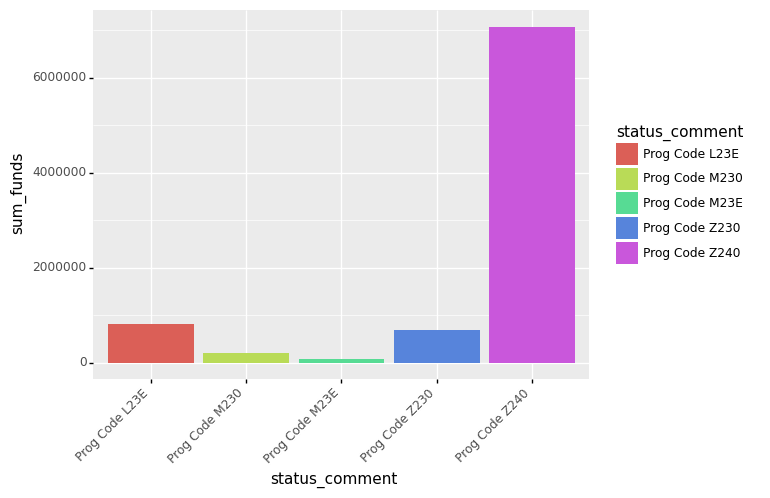

<ggplot: (8788543863682)>

In [37]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

##### 2. Napa County

* 6429(023) / 2018-01-01

In [38]:
df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
1696,1696,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,40000.00,0.00,40000.00,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1697,1697,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,36579.34,0.00,36579.34,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1698,1698,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,2992.04,0.00,2992.04,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1699,1699,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,34226.84,0.00,34226.84,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1700,1700,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,19844.41,0.00,19844.41,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1701,1701,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,19501.56,0.00,19501.56,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1702,1702,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,127042.68,0.00,127042.68,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1703,1703,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,89685.61,0.00,89685.61,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1704,1704,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,112721.92,0.00,112721.92,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1705,1705,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,24536.60,0.00,24536.60,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01


In [ ]:
# agian, not much infomation... 
# we have a program code of FTASTPL but no other descriptions

In [39]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L230,3
1,Prog Code L23E,4
2,Prog Code M23E,3


In [40]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> summarize(sum_funds = _.total_requested.sum())
)

,sum_funds
0,507131.00


In [41]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds2 = _.total_requested.sum())
)

,status_comment,sum_funds2
0,Prog Code L230,79571.38
1,Prog Code L23E,200615.49
2,Prog Code M23E,226944.13


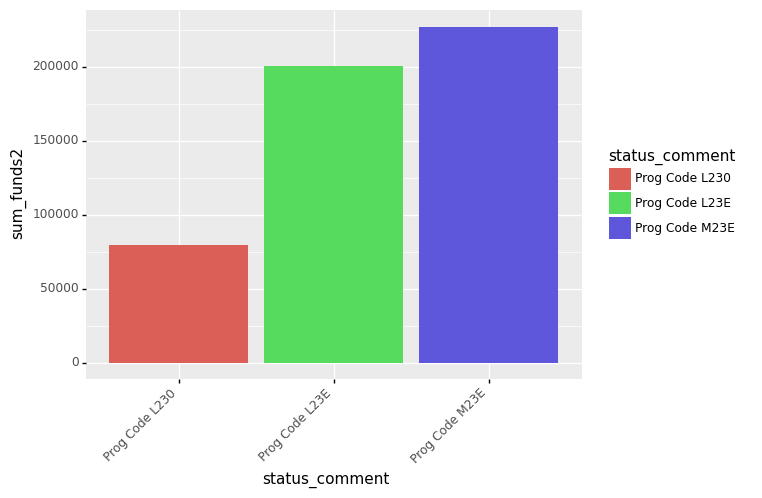

<ggplot: (8788543744350)>

In [42]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds2 = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds2", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)


#####  3. Access Services
* 6312(022) / 2016-01-01
* 6312(027) / 2019-01-01

In [44]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
7096,7096,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,4000000.00,0.00,4000000.00,Prog Code L23R,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7097,7097,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,6000000.00,0.00,6000000.00,Prog Code M230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7098,7098,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,2300000.00,0.00,2300000.00,Prog Code M230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7099,7099,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,51000000.00,0.00,51000000.00,Prog Code Z230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7100,7100,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,2300000.00,0.00,2300000.00,Prog Code M230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7101,7101,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,51000000.00,0.00,51000000.00,Prog Code Z230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7192,7192,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,6000000.00,0.00,6000000.00,Prog Code M230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7193,7193,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,2300000.00,0.00,2300000.00,Prog Code M230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7194,7194,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,51000000.00,0.00,51000000.00,Prog Code Z230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01


In [45]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L23R,1
1,Prog Code M230,5
2,Prog Code Z230,3


In [46]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code L23R,4000000.00
1,Prog Code M230,18900000.00
2,Prog Code Z230,153000000.00


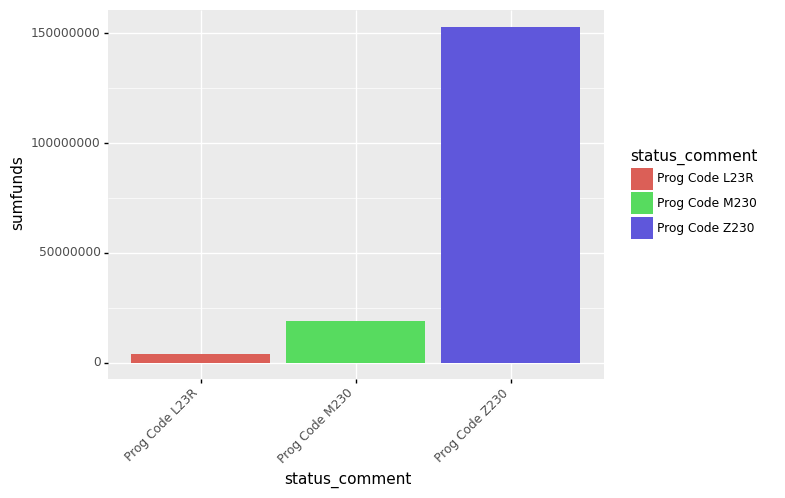

<ggplot: (8788543673293)>

In [47]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [48]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14359,14359,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,39708454.06,0.00,39708454.06,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14360,14360,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,1586162.94,0.00,1586162.94,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14389,14389,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,39708454.06,0.00,39708454.06,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14390,14390,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,1586162.94,0.00,1586162.94,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14400,14400,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,39708454.06,0.00,39708454.06,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14401,14401,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,1586162.94,0.00,1586162.94,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01


In [49]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z230,6


In [50]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z230,123883851.00


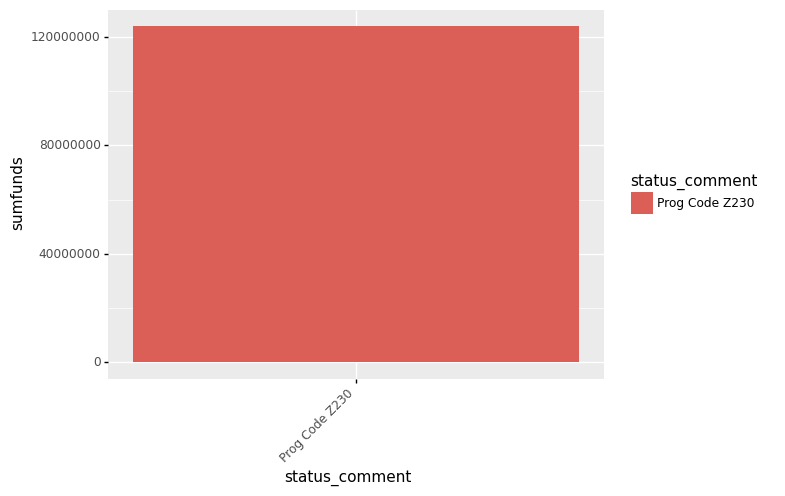

<ggplot: (8788543634231)>

In [51]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

#####  4. Los Angeles County MTA 

* 6065(199) / 2015-01-01
* 6065(225) / 2018-01-01
* 6065(235) / 2019-01-01

In [52]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
8534,8534,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,723000.00,0.00,723000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8535,8535,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,542000.00,0.00,542000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8536,8536,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,878000.00,0.00,878000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8537,8537,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,220000.00,0.00,220000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8538,8538,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,865000.00,0.00,865000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8539,8539,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,1727000.00,0.00,1727000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8540,8540,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,309000.00,0.00,309000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8541,8541,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,424000.00,0.00,424000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8542,8542,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,1265000.00,0.00,1265000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01


In [53]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code M400,9


In [54]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds3= _.total_requested.sum())
)

,status_comment,sum_funds3
0,Prog Code M400,6953000.00


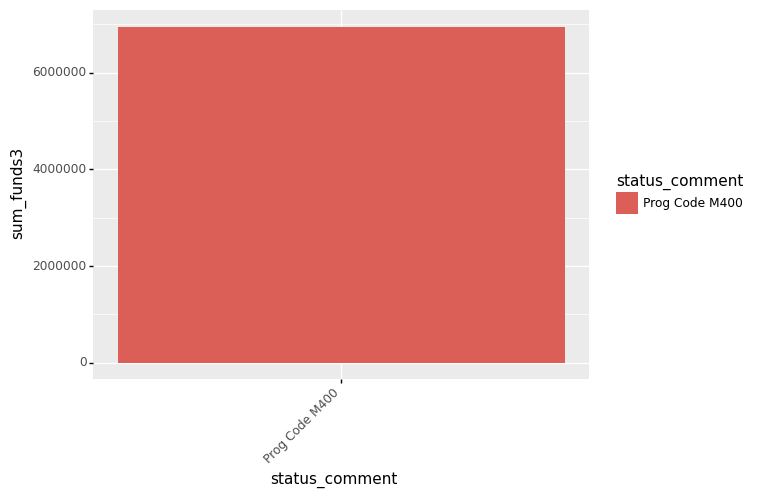

<ggplot: (8788543576049)>

In [55]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds3= _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds3", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [56]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
723,723,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,683000.00,0.00,683000.00,Prog Code Z300,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
724,724,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,260605.00,0.00,260605.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
725,725,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,243263.00,0.00,243263.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
726,726,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,39939.00,0.00,39939.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
727,727,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,315546.00,0.00,315546.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
728,728,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,320849.00,0.00,320849.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
729,729,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,239192.00,0.00,239192.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
730,730,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,197545.00,0.00,197545.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
731,731,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,164061.00,0.00,164061.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01


In [57]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z300,1
1,Prog Code Z301,8


In [58]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds = _.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z300,683000.00
1,Prog Code Z301,1781000.00


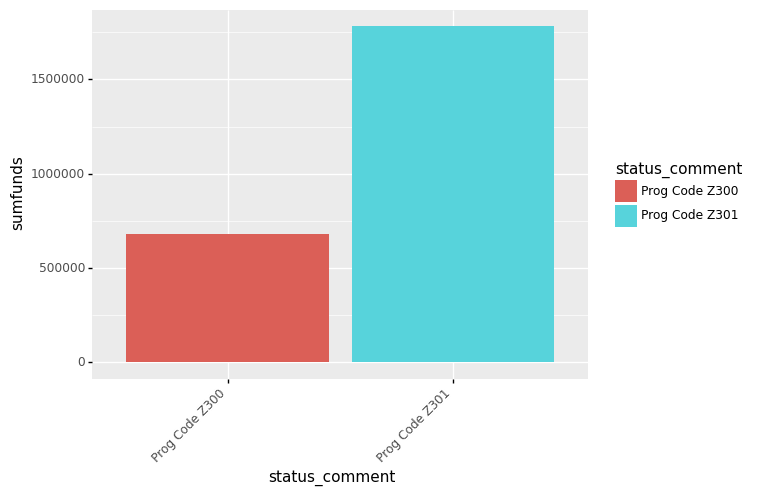

<ggplot: (8788543571408)>

In [59]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [60]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14355,14355,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,5039724.82,0.00,5039724.82,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14356,14356,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,1018434.71,0.00,1018434.71,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14387,14387,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,5039724.82,0.00,5039724.82,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14388,14388,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,1018434.71,0.00,1018434.71,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14396,14396,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,5039724.82,0.00,5039724.82,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14397,14397,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,1018434.71,0.00,1018434.71,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01


In [61]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z400,6


In [62]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z400,18174478.59


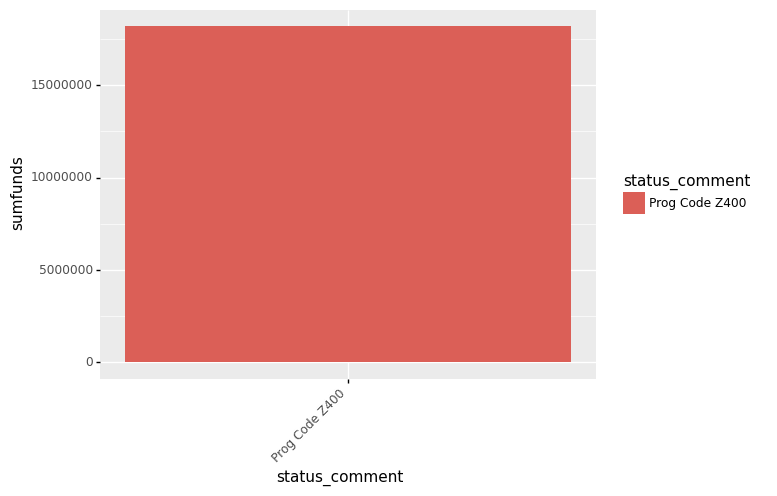

<ggplot: (8788543536999)>

In [63]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)



#####  5. San Diego Metropolitan Tranit System

* 7503(001)  / 2020-01-01

In [64]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01'))


,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
17093,17095,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,9342958.12,0.00,9342958.12,Prog Code Z230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17094,17096,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.65,0.00,0.65,Prog Code H230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17095,17097,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,1312.48,0.00,1312.48,Prog Code L230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17096,17098,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.51,0.00,0.51,Prog Code L23E,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17097,17099,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,12354.63,0.00,12354.63,Prog Code L23R,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17098,17100,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.12,0.00,0.12,Prog Code Q230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17099,17101,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,243373.49,0.00,243373.49,Prog Code 33C0,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01


In [65]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> count(_.status_comment)
)


,status_comment,n
0,Prog Code 33C0,1
1,Prog Code H230,1
2,Prog Code L230,1
3,Prog Code L23E,1
4,Prog Code L23R,1
5,Prog Code Q230,1
6,Prog Code Z230,1


In [66]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds4=_.total_requested.sum())
)

,status_comment,sum_funds4
0,Prog Code 33C0,243373.49
1,Prog Code H230,0.65
2,Prog Code L230,1312.48
3,Prog Code L23E,0.51
4,Prog Code L23R,12354.63
5,Prog Code Q230,0.12
6,Prog Code Z230,9342958.12


In [ ]:
# three program coodes under a dollar...?

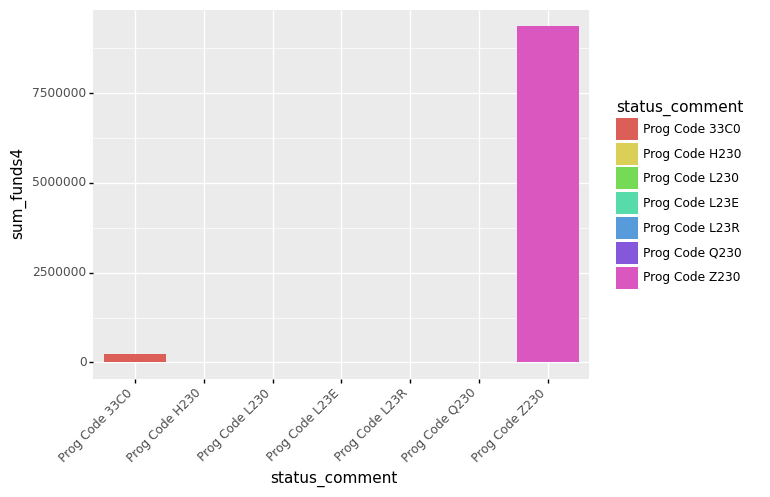

<ggplot: (8788543470936)>

In [67]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds4=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds4", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

#### Trying another approach for non-FTA oblgiations

In [68]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 3)
)

,prefix,agency,project_no,prepared_y,n
9430,FTFERPL16,San Joaquin Regional Rail Commission,6262(020),2019-01-01,5
9481,HP21L,Compton,5078(012),2018-01-01,5
14407,STP,Brawley,5167(037),2018-01-01,5
15036,STP,Huron,5305(014),2014-01-01,5
16084,STP,San Jose,5005(163),2020-01-01,5
16750,STPLER,Calipatria,5243(002),2016-01-01,5
569,ATP,Berkeley,5057(043),2021-01-01,4
648,ATP,Fresno,5060(291),2015-01-01,4
863,ATP,Redding,5068(055),2020-01-01,4
1084,ATPCML,South Lake Tahoe,5398(012),2020-01-01,4


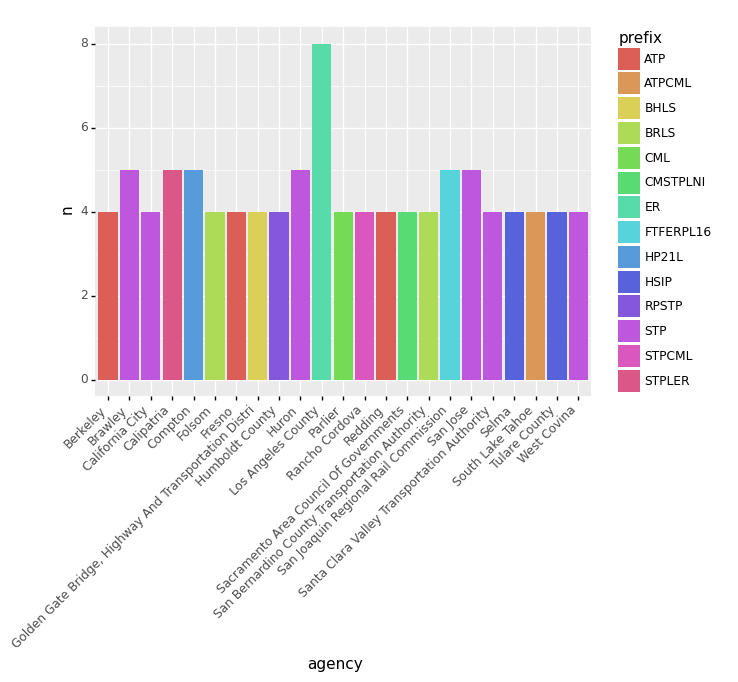

<ggplot: (8788543583419)>

In [69]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 3)
    >> ggplot(aes("agency", "n", fill="prefix")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [70]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 4)
)

,prefix,agency,project_no,prepared_y,n
9430,FTFERPL16,San Joaquin Regional Rail Commission,6262(020),2019-01-01,5
9481,HP21L,Compton,5078(012),2018-01-01,5
14407,STP,Brawley,5167(037),2018-01-01,5
15036,STP,Huron,5305(014),2014-01-01,5
16084,STP,San Jose,5005(163),2020-01-01,5
16750,STPLER,Calipatria,5243(002),2016-01-01,5


In [ ]:
# exploring these obligations in hopes that these have more information 

In [71]:
(df
    >> filter(_.agency == 'San Joaquin Regional Rail Commission',
             _.project_no == '6262(020)',
             _.prepared_y == '2019-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14555,14555,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,5439847.00,0.00,5439847.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01
14556,14556,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,1439840.00,0.00,1439840.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01
14559,14559,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,5439847.00,0.00,5439847.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01
14560,14560,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,1439840.00,0.00,1439840.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01
14561,14561,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,1439840.00,0.00,1439840.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01


In [ ]:
# These are also FTA Transfers, program codes are all the same

In [72]:
(df
    >> filter(_.agency == 'Compton',
             _.project_no == '5078(012)',
             _.prepared_y == '2018-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
801,801,Obligated,HP21L,5078(012),Compton,2018-08-08,2018-08-08,2018-08-08,2018-08-08,2018-08-14,13.85,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,0.00,6.00,NaN,Citywide,Traf. Signal System Upgrade &,7,NaT,NaT,SCAG,NaN,5078,12,True,2018-08-01,2018-01-01
852,852,Obligated,HP21L,5078(012),Compton,2018-07-25,2018-07-25,2018-07-25,2018-07-31,2018-08-07,0.00,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,6.00,7.00,NaN,Citywide,Traf. Signal System Upgrade &,6,NaT,NaT,SCAG,NaN,5078,12,True,2018-07-01,2018-01-01
1571,1571,Obligated,HP21L,5078(012),Compton,2018-05-09,2018-05-09,2018-05-09,2018-05-09,2018-05-18,0.00,0.00,1275883.59,Authorized,5078,7,E-76 approved on,NaN,0.00,9.00,NaN,Citywide,Traf. Signal System Upgrade &,5,NaT,NaT,SCAG,NaN,5078,12,True,2018-05-01,2018-01-01
2109,2109,Obligated,HP21L,5078(012),Compton,2018-03-26,2018-03-26,2018-03-26,2018-03-26,2018-03-28,-647759.57,0.00,-648816.92,Authorized,5078,7,E-76 approved on,NaN,0.00,2.00,NaN,Citywide,Traf. Signal System Upgrade &,4,NaT,NaT,SCAG,NaN,5078,12,True,2018-03-01,2018-01-01
13996,13996,Obligated,HP21L,5078(012),Compton,2018-08-31,2018-08-31,2018-08-31,2018-12-31,2019-01-03,0.00,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,122.00,3.00,NaN,Citywide,Traf. Signal System Upgrade &,8,NaT,NaT,SCAG,NaN,5078,12,True,2018-08-01,2018-01-01


In [ ]:
#these have different sequences, projects city-wide

In [73]:
(df
    >> filter(_.agency == 'Brawley',
             _.project_no == '5167(037)',
             _.prepared_y == '2018-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
457,457,Obligated,STP,5167(037),Brawley,2018-09-28,2018-09-28,2018-09-28,2018-10-10,2018-10-16,-0.15,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,12.00,6.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",6,NaT,NaT,SCAG,NaN,5167,37,True,2018-09-01,2018-01-01
986,986,Obligated,STP,5167(037),Brawley,2018-07-11,2018-07-11,2018-07-11,2018-07-11,2018-07-18,0.00,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,7.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",5,NaT,NaT,SCAG,NaN,5167,37,True,2018-07-01,2018-01-01
1071,1071,Obligated,STP,5167(037),Brawley,2018-07-02,2018-07-02,2018-07-02,2018-07-02,2018-07-10,0.00,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,8.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",4,NaT,NaT,SCAG,NaN,5167,37,True,2018-07-01,2018-01-01
1250,1250,Obligated,STP,5167(037),Brawley,2018-06-25,2018-06-25,2018-06-25,2018-06-25,2018-06-28,0.15,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,3.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",3,NaT,NaT,SCAG,NaN,5167,37,True,2018-06-01,2018-01-01
1575,1575,Obligated,STP,5167(037),Brawley,2018-05-07,2018-05-07,2018-05-07,2018-05-07,2018-05-18,-151665.65,0.00,-171316.15,Authorized,5167,11,E-76 approved on,11.00,0.00,11.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",2,2018-04-26,2018-05-07,SCAG,NaN,5167,37,True,2018-05-01,2018-01-01


In [ ]:
# multiple segment project, no first sequence, and the oblogated amounts are near zero or below zero. 

In [74]:
(df
    >> filter(_.agency == 'Huron',
             _.project_no == '5305(014)',
             _.prepared_y == '2014-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
10547,10547,Obligated,STP,5305(014),Huron,2014-10-30,2014-10-30,2014-10-31,2014-11-06,2014-11-07,-27745.00,0.00,-45575.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,7.00,1.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),5,NaT,NaT,CFCG,NaN,5305,14,True,2014-10-01,2014-01-01
11138,11138,Obligated,STP,5305(014),Huron,2014-07-16,2014-07-23,2014-07-28,2014-08-05,2014-08-05,350000.00,0.00,367830.00,Authorized,5305,6,E-76 approved on E-76 approved on,7.00,13.00,0.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),4,NaT,NaT,CFCG,NaN,5305,14,True,2014-07-01,2014-01-01
11651,11651,Obligated,STP,5305(014),Huron,2014-06-10,2014-06-10,2014-06-10,2014-06-18,2014-06-20,0.00,0.00,0.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,8.00,2.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),3,NaT,NaT,CFCG,NaN,5305,14,True,2014-06-01,2014-01-01
11881,11881,Obligated,STP,5305(014),Huron,2014-05-16,2014-05-16,2014-05-16,2014-05-16,2014-05-19,0.00,0.00,0.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,0.00,3.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),2,NaT,NaT,CFCG,NaN,5305,14,True,2014-05-01,2014-01-01
12019,12019,Obligated,STP,5305(014),Huron,2014-04-21,2014-04-21,2014-04-24,2014-04-28,2014-04-29,42000.00,0.00,42000.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,7.00,1.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),1,NaT,NaT,CFCG,NaN,5305,14,True,2014-04-01,2014-01-01


In [ ]:
#another multi-segment project for road construction 

In [75]:
(df
    >> filter(_.agency == 'San Jose',
             _.project_no == '5005(163)',
             _.prepared_y == '2020-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
16510,16512,Obligated,STP,5005(163),San Jose,2020-04-13,2020-05-07,2020-05-11,2020-05-12,2020-05-13,0.00,16642138.00,23471782.00,Authorized,5005,4,E-76 approved on,52.00,5.00,1.00,scl170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,1,2020-03-16,2020-05-06,MTC,NaN,5005,163,True,2020-04-01,2020-01-01
17165,17167,Obligated,STP,5005(163),San Jose,2020-09-01,2020-09-01,2020-09-02,2020-09-11,2020-09-16,2483075.89,-2483075.89,-0.00,Authorized,5005,4,E-76 approved on,NaN,10.00,5.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,2,NaT,NaT,MTC,NaN,5005,163,True,2020-09-01,2020-01-01
17554,17556,Obligated,STP,5005(163),San Jose,2020-11-02,2020-11-02,2020-11-06,2020-11-06,2020-11-13,0.00,0.00,-2288474.00,Authorized,5005,4,E-76 approved on,10.00,4.00,7.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,3,2020-10-23,2020-10-30,MTC,NaN,5005,163,True,2020-11-01,2020-01-01
17928,17930,Obligated,STP,5005(163),San Jose,2020-12-22,2020-12-22,2020-12-28,2020-12-30,2021-01-07,14159062.11,-14159062.11,0.00,Authorized,5005,4,E-76 approved on,1.00,8.00,8.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,4,2020-12-21,2020-12-22,MTC,NaN,5005,163,True,2020-12-01,2020-01-01
18165,18167,Obligated,STP,5005(163),San Jose,2020-12-22,2020-12-22,2020-12-28,2020-12-30,2021-01-07,14159062.11,-14159062.11,0.00,Authorized,5005,4,E-76 approved on,1.00,8.00,8.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,4,2020-12-21,2020-12-22,MTC,NaN,5005,163,True,2020-12-01,2020-01-01


In [ ]:
# another double entry- possibly a refund (?) since it is negative funds.


In [76]:
(df
    >> filter(_.agency == 'Calipatria',
             _.project_no == '5243(002)',
             _.prepared_y == '2016-01-01')
)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
6057,6057,Obligated,STPLER,5243(002),Calipatria,2016-08-03,2016-08-03,2016-08-03,2016-08-03,2016-08-11,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,8.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",9,NaT,NaT,SCAG,NaN,5243,2,True,2016-08-01,2016-01-01
6550,6550,Obligated,STPLER,5243(002),Calipatria,2016-06-03,2016-06-03,2016-06-03,2016-06-03,2016-06-21,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/6/2015,0.00,0.00,18.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",8,NaT,NaT,SCAG,NaN,5243,2,True,2016-06-01,2016-01-01
6878,6878,Obligated,STPLER,5243(002),Calipatria,2016-04-22,2016-04-22,2016-04-22,2016-04-22,2016-05-09,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/6/2015,0.00,0.00,17.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",7,NaT,NaT,SCAG,NaN,5243,2,True,2016-04-01,2016-01-01
7073,7073,Obligated,STPLER,5243(002),Calipatria,2016-04-05,2016-04-05,2016-04-05,2016-04-05,2016-04-11,0.00,0.00,445709.54,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,6.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",6,NaT,NaT,SCAG,NaN,5243,2,True,2016-04-01,2016-01-01
7109,7109,Obligated,STPLER,5243(002),Calipatria,2016-03-23,2016-03-23,2016-03-23,2016-03-23,2016-04-01,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,9.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",5,NaT,NaT,SCAG,NaN,5243,2,True,2016-03-01,2016-01-01


In [ ]:
# intersting to see another group of obligations have no funds attached to them. 


### Filtering by agency and year and type of work

In [77]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.n >= 50)
)

,agency,prepared_y,n
1158,Humboldt County,2018-01-01,171
1159,Humboldt County,2019-01-01,147
1519,Los Angeles,2014-01-01,110
2860,Santa Cruz County,2018-01-01,107
2861,Santa Cruz County,2019-01-01,104
1160,Humboldt County,2020-01-01,88
1520,Los Angeles,2015-01-01,85
1735,Modesto,2018-01-01,85
952,Fresno,2015-01-01,83
1533,Los Angeles County,2019-01-01,77


In [78]:
(df
    >> group_by(_.agency, _.type_of_work, _.prepared_y)
    >> count(_.prefix) 
    >> arrange(-_.n)
    >> filter(_.n > 10)
)

,agency,type_of_work,prepared_y,prefix,n
4302,Humboldt County,Storm Damage Restoration,2018-01-01,ER,84
4211,Humboldt County,Permanent Restoration,2019-01-01,ER,47
4208,Humboldt County,Permanent Restoration,2018-01-01,ER,36
4209,Humboldt County,Permanent Restoration,2019-01-01,ACST-ER,27
10732,San Bernardino County,Replace Two Lane Timber Bridge With Two Lane B...,2021-01-01,BRLS,18
4214,Humboldt County,Permanent Restoration,2020-01-01,ER,17
6901,Mendocino County,Permanent Restoration,2018-01-01,ER,17
3170,Fresno,Ac Overlay (tc),2016-01-01,STP,16
3173,Fresno,Ac Overlay (tc),2019-01-01,STP,16
4217,Humboldt County,Permanent Restoration,2021-01-01,ER,16
